# Task 1: Big Cats
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [1]:
import os

import cv2 as cv
import imgaug.augmenters as iaa
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, silhouette_samples, silhouette_score, mutual_info_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import label_binarize
from sklearn.cluster import DBSCAN, Birch, KMeans
from fcmeans import FCM

In [2]:
RANDOM_STATE=42

In [3]:
data_path = os.path.join("..", "Data-PR-As2", "BigCats")

In [4]:
class_paths = os.listdir(data_path)
imgs = []
labels = []
for class_ in class_paths:
    path = os.path.join(data_path, class_)
    imgs_of_class = os.listdir(path)
    imgs += [os.path.join(path, x) for x in imgs_of_class]
    labels += [class_] * len(imgs_of_class)

## Data Analysis

In [5]:
print("# observations:", len(labels))

# observations: 200


In [6]:
classes = list(np.unique(labels))
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

There are 5 classes: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']


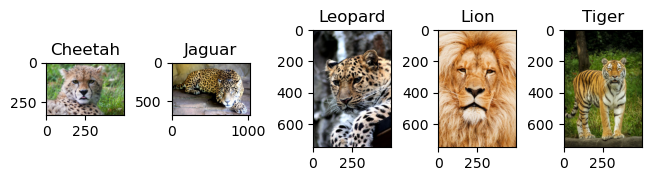

In [7]:
# Visualise one data sample per class
fig, axs = plt.subplots(1, n_classes, constrained_layout=True)
axs = axs.flatten()

for i, class_ in enumerate(classes):
    ob_idx = labels.index(class_)
    with Image.open(imgs[ob_idx]) as img:
        axs[i].imshow(img)
        axs[i].title.set_text(class_)
plt.show()

In [8]:
def plot_class_freq(y):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    if matplotlib.__version__[:3] != "3.3":
        ax.bar_label(ax.containers[0])
    else:
        print("Warning using old version of matplotlib!")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

Warning using old version of matplotlib!


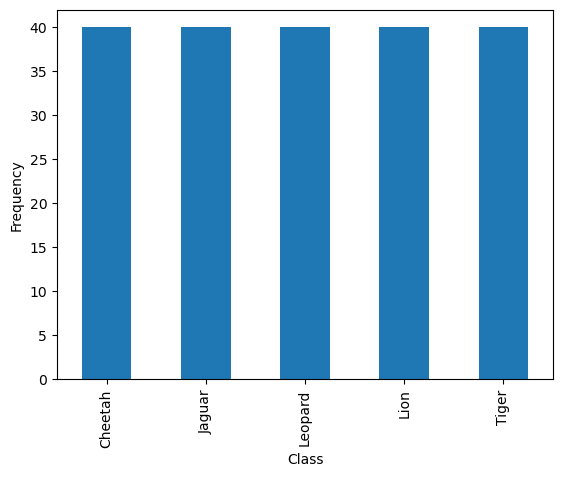

In [9]:
# Check for data imbalance
plot_class_freq(pd.DataFrame(labels))

## Data Augmentation

In [10]:
def aug_data(data, labels, display_idx={}):
    all_imgs = []
    all_labels = []
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.6, random_state=RANDOM_STATE),
        iaa.PiecewiseAffine(scale=(0.03, 0.05), random_state=RANDOM_STATE),
        iaa.PerspectiveTransform(scale=(0.07, 0.15), random_state=RANDOM_STATE)
    ])

    for i, x in enumerate(data):
        img = cv.imread(x)
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        aug_img = aug_seq(images=[img])

        all_imgs.append(img)
        all_imgs.append(aug_img[0])
        all_labels.append(labels[i])
        all_labels.append(labels[i])

        if i in display_idx:
            fig, axs = plt.subplots(1, 2, constrained_layout=True)
            axs = axs.flatten()
            axs[0].imshow(img)
            axs[0].title.set_text('Original')
            axs[1].imshow(aug_img[0])
            axs[1].title.set_text('Augmented')
            plt.show()

    return all_imgs, all_labels

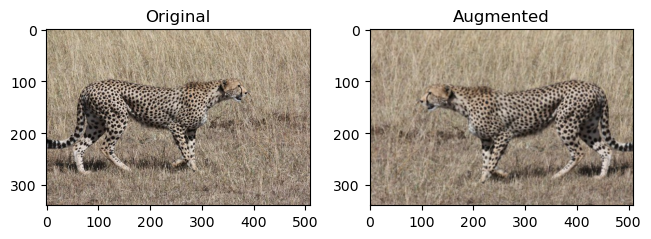

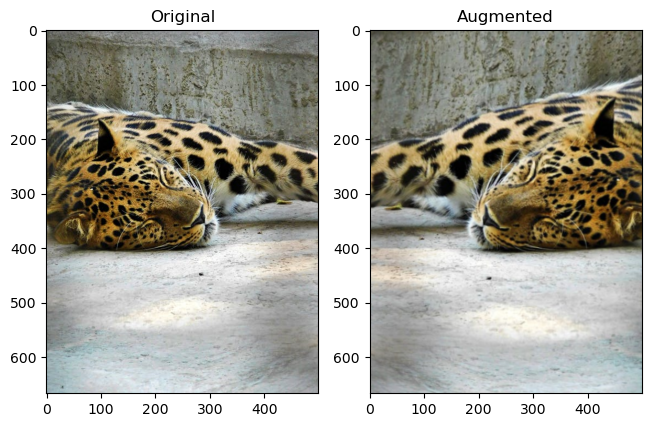

In [11]:
all_imgs, all_labels = aug_data(imgs, labels, {2, 101})

## Classification

In [12]:
img_train, img_test, label_train, label_test = train_test_split(all_imgs, all_labels, test_size=0.2, random_state=RANDOM_STATE)

### Feature extraction
The features will be extracted using SIFT and ORB.

In [13]:
def extract_features(detector, data, display_idxs={}):
    features = np.array([])
    
    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        kp, des = detector.detectAndCompute(bw_img, None)
        features = np.vstack((des, features)) if features.size else des

        if i in display_idxs:
            img_sift = cv.drawKeypoints(bw_img, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.imshow(img_sift)
            plt.show()
    return features

### Bag of Visual Words

Create dictionary by clustering descriptors

In [14]:
def get_kmeans_dict(train_features, cluster_num):
    kmeans = KMeans(n_clusters=cluster_num, random_state=RANDOM_STATE)
    kmeans.fit(train_features)
    return kmeans

Helper functions

In [15]:
# Returns a normalized histogram of the dictionary word frequency
# using the SIFT descriptors of an image
def build_histogram(kmeans_dict, img_des, n_clusters):
    pred = kmeans_dict.predict(img_des)
    hist, _ = np.histogram(pred, bins=n_clusters)
    hist_norm = [float(i)/sum(hist) for i in hist]
    return hist

Extract BoVW features

In [16]:
def get_BOVW_feat(data, labels, kmeans_dict, detector, n_clusters):
    features = []
    for id in range(len(data)):
        if data[id] is not None:
            d = [data[id]]
            features.append(build_histogram(kmeans_dict, extract_features(detector, d), n_clusters))
        else:
            labels.pop(id)
    return features, labels

### Evaluation

In [17]:
def get_f1_score(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)
    return f1_score(test_labels, yhat, average='macro')

In [18]:
def evaluate_model(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)

    accuracy = accuracy_score(test_labels, yhat)
    print("Accuracy: {}%".format(accuracy * 100))

    f_1 = f1_score(test_labels, yhat, average='macro')
    print("F_1: {}".format(f_1))

    conf_mat = confusion_matrix(test_labels, yhat)
    conf_mat_df = pd.DataFrame(conf_mat, columns=classes, index=classes)
    sns.set(rc={'figure.facecolor':'white'})
    fig = sns.heatmap(conf_mat_df, annot=True, cmap=sns.cm.rocket_r)
    plt.show()

    all_classes = np.unique(test_labels)
    bin_label_test = label_binarize(test_labels, classes=all_classes)
    try:
        label_score = model.predict_proba(test_data)
    except:
        label_score = model.decision_function(test_data)
        
    # from sklearn documentation on roc curves with changed var names
    false_pos_rate = dict()
    true_pos_rate = dict()
    auc_scores = dict()
    for n_class in range(len(all_classes)):
        false_pos_rate[n_class], true_pos_rate[n_class], _ = roc_curve(bin_label_test[:, n_class], label_score[:, n_class])
        auc_scores[n_class] = auc(false_pos_rate[n_class], true_pos_rate[n_class])
        print("Class: {}, AUC: {}".format(all_classes[n_class], auc_scores[n_class]))
        plt.plot(false_pos_rate[n_class], true_pos_rate[n_class], label=classes[n_class]+" (area = {0:0.2f})".format(auc_scores[n_class]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="best")
    plt.show()

### Run model

In [19]:
def run_model_grid_search(detector, data_train, label_train, data_test, label_test, n_clusters):
    f1_df = pd.DataFrame(columns=['method','n_estimators','criterion','kernel','n_neighbors','weights','f1-score'])
    all_train_features = extract_features(detector, img_train)

    kmeans_dict = get_kmeans_dict(all_train_features, n_clusters)
    kmeans_train_features, label_train = get_BOVW_feat(data_train, label_train, kmeans_dict, detector, n_clusters)
    kmeans_test_features, label_test = get_BOVW_feat(data_test, label_test, kmeans_dict, detector, n_clusters)

    rfc_criterion = ['gini', 'entropy', 'log_loss']
    rfc_n_estimators = [50, 100, 150, 200]
    for criterion in rfc_criterion:
        for n_estimators in rfc_n_estimators:
            f1 = get_f1_score(RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, random_state=RANDOM_STATE, n_jobs=-1),\
                kmeans_train_features, label_train, kmeans_test_features, label_test)
            new_row = pd.DataFrame({'method':['rfc'], 'n_estimators':[n_estimators], 'criterion':[criterion], 'f1-score':[f1]})
            f1_df = pd.concat([f1_df, new_row], ignore_index=True)
            

    svm_kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    for kernel in svm_kernel:
        f1 = get_f1_score(SVC(kernel=kernel), kmeans_train_features, label_train, kmeans_test_features, label_test)
        new_row = pd.DataFrame({'method':['svm'], 'kernel':[kernel], 'f1-score':[f1]})
        f1_df = pd.concat([f1_df, new_row], ignore_index=True)

    knn_n_neighbors = [3, 5, 7]
    knn_weights = ['uniform', 'distance']
    for n_neighbors in knn_n_neighbors:
        for weights in knn_weights:
            f1 = get_f1_score(KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1),\
                kmeans_train_features, label_train, kmeans_test_features, label_test)
            new_row = pd.DataFrame({'method':['knn'], 'n_neighbors':[n_neighbors], 'weights':[weights], 'f1-score':[f1]})
            f1_df = pd.concat([f1_df, new_row], ignore_index=True)

    return f1_df

In [20]:
def run_model(detector, img_train, label_train, img_test, label_test, n_clusters):
    all_train_features = extract_features(detector, img_train, display_idxs={0, 5})

    kmeans_dict = get_kmeans_dict(all_train_features, n_clusters)
    kmeans_train_features, label_train = get_BOVW_feat(img_train, label_train, kmeans_dict, detector, n_clusters)
    kmeans_test_features, label_test = get_BOVW_feat(img_test, label_test, kmeans_dict, detector, n_clusters)

    print("Evaluation with Random Forest Classifier:")
    evaluate_model(RandomForestClassifier(random_state=RANDOM_STATE), kmeans_train_features, label_train, kmeans_test_features, label_test)

    print("\nEvaluation with SVM:")
    evaluate_model(SVC(), kmeans_train_features, label_train, kmeans_test_features, label_test)

    print("\nEvaluation with KNN Classifier:")
    evaluate_model(KNeighborsClassifier(), kmeans_train_features, label_train, kmeans_test_features, label_test)

    return kmeans_train_features, label_train, kmeans_test_features, label_test

### Cross validation

In [21]:
def cross_validation(detector, data, labels, n_clusters, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    f1_df = pd.DataFrame(columns=['method','n_estimators','criterion','kernel','n_neighbors','weights','f1-score'])

    for train_index, test_index in kf.split(data):
        data_train, data_test = [data[index] for index in train_index], [data[index] for index in test_index]
        labels_train, labels_test = [labels[index] for index in train_index], [labels[index] for index in test_index]
        f1_df = pd.concat([f1_df,run_model_grid_search(detector, data_train, labels_train,data_test, labels_test, n_clusters)],ignore_index=True)
    f1_mean_df = f1_df.groupby(['method','n_estimators','criterion','kernel','n_neighbors','weights'], dropna=False).mean().reset_index()
    f1_sd_df = f1_df.groupby(['method','n_estimators','criterion','kernel','n_neighbors','weights'], dropna=False).std().reset_index()
    f1_mean_df['sd'] = f1_sd_df['f1-score']

    best_rfc = f1_mean_df.where(f1_mean_df.method == 'rfc')['f1-score'].idxmax()
    best_svm = f1_mean_df.where(f1_mean_df.method == 'svm')['f1-score'].idxmax()
    best_knn = f1_mean_df.where(f1_mean_df.method == 'knn')['f1-score'].idxmax()

    return pd.concat([f1_mean_df.loc[[best_rfc]], f1_mean_df.loc[[best_svm]], f1_mean_df.loc[[best_knn]]], ignore_index=True)

### Grid search

In [22]:
def grid_search(detector, img_train, label_train, k):
    tried_cluster_ns = []
    rfc_f1 = []
    svm_f1 = []
    knn_f1 = []

    # The search starts with 50 clusters and will be incremented at each iteration
    n_clusters = 50
    step = 50

    # Counts if performance has been unchanged or lower for each classifier
    lower = [0, 0, 0]
    prev_f1 = [0, 0, 0]

    while min(lower) < 2:
        print("Mean F1-score (\u00B1 1 SD) for {} clusters after {}-fold cross validation:".format(n_clusters, k))
        f1_df = cross_validation(detector, img_train, label_train, n_clusters, k)
        mean = [f1_df.loc[f1_df['method'] == 'rfc', 'f1-score'].item(), f1_df.loc[f1_df['method'] == 'svm', 'f1-score'].item(),\
             f1_df.loc[f1_df['method'] == 'knn', 'f1-score'].item()]
        print("\t- RFC, n_estimators={}, criterion={}: {} \u00B1 {}".format(f1_df.loc[f1_df['method'] == 'rfc', 'n_estimators'].item(),\
            f1_df.loc[f1_df['method'] == 'rfc', 'criterion'].item(), mean[0], f1_df.loc[f1_df['method'] == 'rfc', 'sd'].item()))
        print("\t- SVM, kernel={}: {} \u00B1 {}".format(f1_df.loc[f1_df['method'] == 'svm', 'kernel'].item(), mean[1],\
             f1_df.loc[f1_df['method'] == 'svm', 'sd'].item()))
        print("\t- KNN, n_neighbors={}, weights={}: {} \u00B1 {}\n".format(f1_df.loc[f1_df['method'] == 'knn', 'n_neighbors'].item(),\
            f1_df.loc[f1_df['method'] == 'knn', 'weights'].item(), mean[2], f1_df.loc[f1_df['method'] == 'knn', 'sd'].item()))
        rfc_f1.append(mean[0])
        svm_f1.append(mean[1])
        knn_f1.append(mean[2])

        tried_cluster_ns.append(n_clusters)
        n_clusters = n_clusters + step
        for i in range(3):
            if mean[i] <= prev_f1[i]:
                lower[i] = lower[i] + 1
            else:
                lower[i] = 0
            prev_f1[i] = mean[i]

    plt.plot(tried_cluster_ns, rfc_f1, label='Best RFC')
    plt.plot(tried_cluster_ns, svm_f1, label='Best SVM')
    plt.plot(tried_cluster_ns, knn_f1, label='Best KNN')
    plt.xlabel('Number of Clusters')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.show()

## Ensemble

In [23]:
def run_ensembles(clf1, clf2, clf3, kmeans_train_features, label_train, kmeans_test_features, label_test):
    print("\nEvaluation with soft voting:")
    eclf = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('svm', clf3)], voting='soft')
    evaluate_model(eclf, kmeans_train_features, label_train, kmeans_test_features, label_test)

    print("\nEvaluation with stacking:")
    clf = StackingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('svm', clf3)], final_estimator=clf3)
    evaluate_model(clf, kmeans_train_features, label_train, kmeans_test_features, label_test)

## Clustering

In [24]:
def vis_data(data, labels, plot_title):
    mds = MDS(random_state=RANDOM_STATE, n_components=2)
    X_transform = mds.fit_transform(data)

    for class_ in np.unique(labels):
        r_idx = np.where(np.asarray(labels) == class_)
        plt.scatter(X_transform[r_idx, 0], X_transform[r_idx, 1], label=class_)
    plt.title(plot_title)
    plt.xlabel("Coordinate 1")
    plt.ylabel("Coordinate 2")
    plt.legend()
    plt.show()

def clustering_and_vis(model, data, labels):
    vis_data(data, labels, "Original data")
    
    pred = model.fit_predict(data)
    silhouette = silhouette_score(data, pred)
    mutual_info = mutual_info_score(labels, pred)
    print("Silhouette: {} \nMutual information: {}".format(silhouette, mutual_info))

    vis_data(data, pred, "Birch clustering")

## ORB pipeline

### Classification

In [25]:
detector = cv.ORB_create()

#### Grid search

Mean F1-score (± 1 SD) for 50 clusters after 3-fold cross validation:
	- RFC, n_estimators=200.0, criterion=entropy: 0.4978586373386611 ± 0.04671400068621301
	- SVM, kernel=poly: 0.47363061355973946 ± 0.028083384152946058
	- KNN, n_neighbors=3.0, weights=distance: 0.46704508184843746 ± 0.016326742749637496

Mean F1-score (± 1 SD) for 100 clusters after 3-fold cross validation:
	- RFC, n_estimators=150.0, criterion=entropy: 0.4858009327483012 ± 0.06475395642700309
	- SVM, kernel=poly: 0.541106903321745 ± 0.0389510309000926
	- KNN, n_neighbors=3.0, weights=distance: 0.4631788603945757 ± 0.04180331469164752

Mean F1-score (± 1 SD) for 150 clusters after 3-fold cross validation:
	- RFC, n_estimators=200.0, criterion=entropy: 0.4481071355978929 ± 0.03334739961166801
	- SVM, kernel=poly: 0.5056181626897104 ± 0.03373810905502578
	- KNN, n_neighbors=7.0, weights=uniform: 0.44630743281943835 ± 0.08124667256664445

Mean F1-score (± 1 SD) for 200 clusters after 3-fold cross validation:
	- RFC, n_

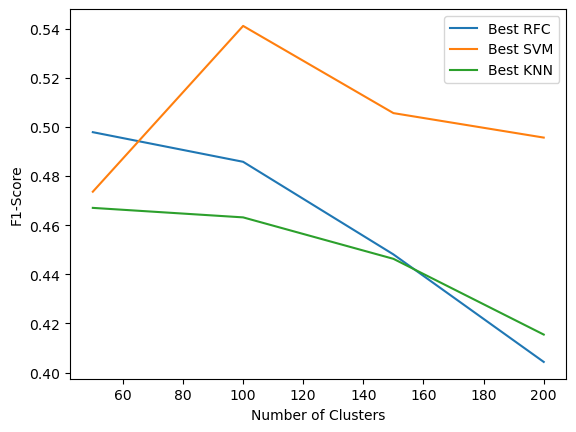

In [26]:
grid_search(detector, img_train, label_train, 3)

In [27]:
# kmeans_train_features, label_train, kmeans_test_features, label_test = run_model(detector,img_train,label_train,img_test,label_test,100)

### Ensemble

In [ ]:
# clf1 = KNeighborsClassifier(n_neighbors=3, weights='distance')
# clf2 = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state=RANDOM_STATE)
# clf3 = SVC(kernel='poly', probability=True)
# run_ensembles(clf1, clf2, clf3, kmeans_train_features, label_train, kmeans_test_features, label_test)

### Clustering

In [29]:
# clustering_and_vis(Birch(threshold=0.03, n_clusters=5), np.vstack((kmeans_train_features, kmeans_test_features)), label_train + label_test)

## SIFT pipeline

### Classification

In [30]:
detector = cv.SIFT_create()

#### Grid search

In [31]:
grid_search(detector, img_train, label_train, 3)

Mean F1-score (± 1 SD) for 50 clusters after 3-fold cross validation:
	- RFC, n_estimators=200.0, criterion=entropy: 0.6663916483007563 ± 0.04336926879712516
	- SVM, kernel=linear: 0.6571478813219971 ± 0.0716141719270801
	- KNN, n_neighbors=3.0, weights=distance: 0.6354550217519391 ± 0.010205564216760455

Mean F1-score (± 1 SD) for 100 clusters after 3-fold cross validation:
	- RFC, n_estimators=200.0, criterion=entropy: 0.6653063786483422 ± 0.0585555950791598
	- SVM, kernel=linear: 0.7444375596840652 ± 0.07553256198457665
	- KNN, n_neighbors=5.0, weights=distance: 0.6703671517896134 ± 0.05173426670931924

Mean F1-score (± 1 SD) for 150 clusters after 3-fold cross validation:
	- RFC, n_estimators=200.0, criterion=entropy: 0.6970714545180852 ± 0.049150866803263714
	- SVM, kernel=linear: 0.7430325158005852 ± 0.05442208271574932
	- KNN, n_neighbors=5.0, weights=distance: 0.6544429775788351 ± 0.03808791741261856

Mean F1-score (± 1 SD) for 200 clusters after 3-fold cross validation:
	- RFC

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


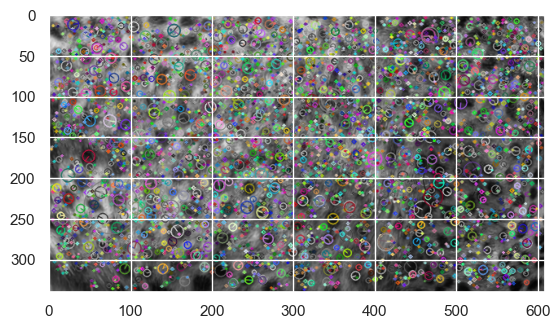

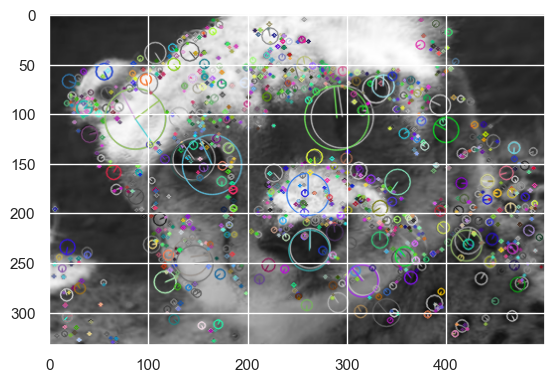

Evaluation with Random Forest Classifier:
Accuracy: 68.75%
F_1: 0.6719358791719895


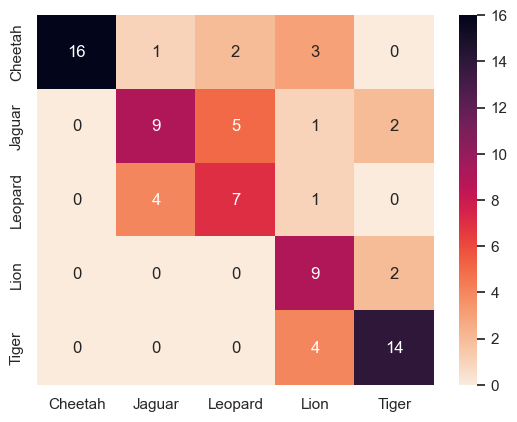

Class: Cheetah, AUC: 0.9275078369905957
Class: Jaguar, AUC: 0.8566760037348272
Class: Leopard, AUC: 0.8553921568627451
Class: Lion, AUC: 0.9341238471673254
Class: Tiger, AUC: 0.961021505376344


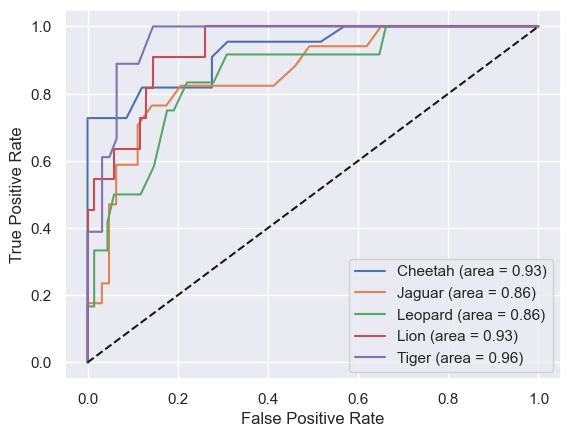


Evaluation with SVM:
Accuracy: 60.0%
F_1: 0.6080398671096344


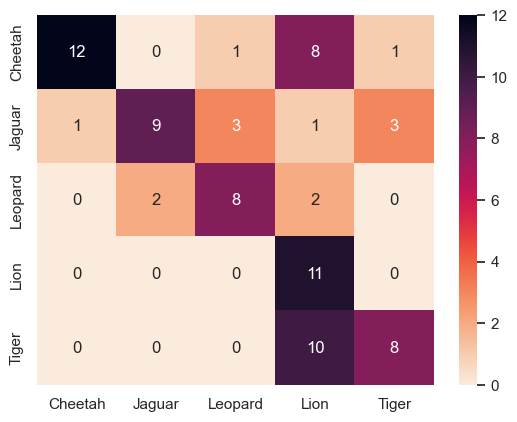

Class: Cheetah, AUC: 0.932601880877743
Class: Jaguar, AUC: 0.8478057889822596
Class: Leopard, AUC: 0.8786764705882353
Class: Lion, AUC: 0.9459815546772069
Class: Tiger, AUC: 0.9184587813620072


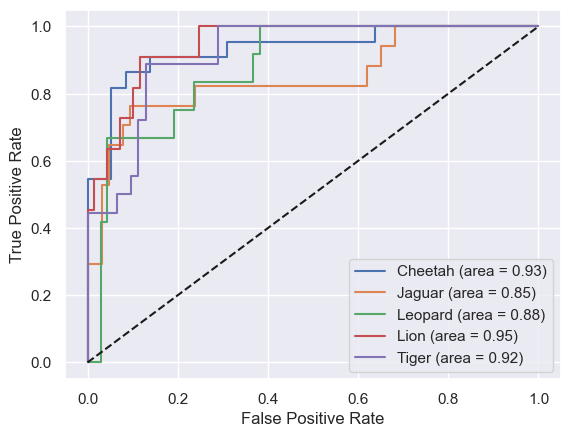


Evaluation with KNN Classifier:
Accuracy: 63.74999999999999%
F_1: 0.6239885783616433


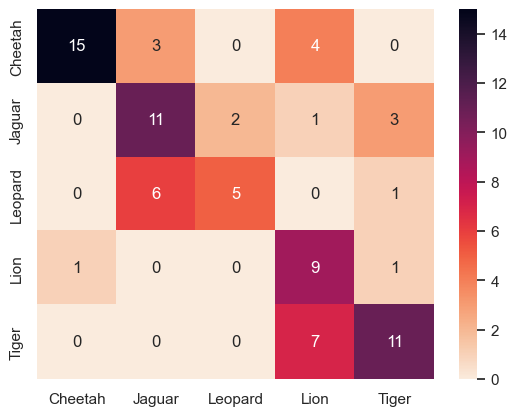

Class: Cheetah, AUC: 0.9373040752351097
Class: Jaguar, AUC: 0.8389355742296918
Class: Leopard, AUC: 0.8737745098039215
Class: Lion, AUC: 0.9216073781291172
Class: Tiger, AUC: 0.9269713261648745


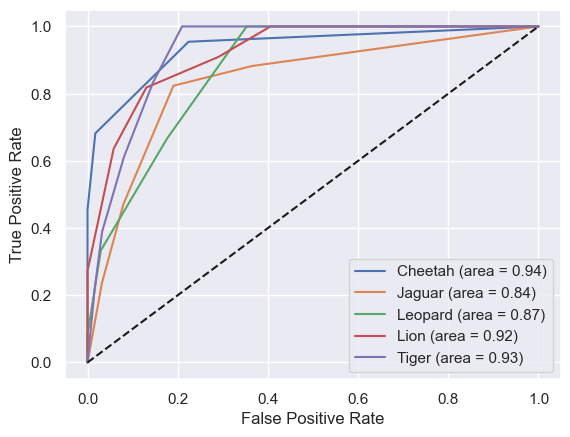

In [ ]:
# kmeans_train_features, label_train, kmeans_test_features, label_test = run_model(detector, img_train, label_train, img_test, label_test, 150)

### Ensemble

In [ ]:
# clf1 = KNeighborsClassifier(n_neighbors=3, weights='distance')
# clf2 = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state=RANDOM_STATE)
# clf3 = SVC(kernel='poly', probability=True)
# run_ensembles(clf1, clf2, clf3, kmeans_train_features, label_train, kmeans_test_features, label_test)

### Clustering

In [ ]:
# clustering_and_vis(Birch(threshold=0.03, n_clusters=5), np.vstack((kmeans_train_features, kmeans_test_features)), label_train + label_test)